In [44]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

import os
import math
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv3D, MaxPool3D, ConvLSTM2D, Flatten, Dense,Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [2]:
train_data = "/kaggle/input/dl-data/Train.csv"
train_vid = "/kaggle/input/dl-data/Train"
valid_data = "/kaggle/input/dl-data/Validation.csv"
valid_vid = "/kaggle/input/dl-data/Validation"
frame_count = 30

In [3]:
def free_ram(a):
    del a[:]
    del a

In [4]:
def read_csv(file_path):
    data = pd.read_csv(file_path,sep = ",",header=None, skiprows=1)
    data = data.set_index(0)[1].to_dict()
    return data

In [5]:
def kepastian_frame(vid_path,hm_frame = frame_count):
    offset = 0

    frames = os.listdir(vid_path)
    frames_count = len(frames)

    if frames_count < hm_frame:
    # Jika frame kurang, tambahkan frame terakhir hingga jumlah sesuai
        frames += [frames[-1]] * (hm_frame - frames_count)
    elif frames_count > hm_frame:
    # Jika frame lebih, potong hingga jumlah sesuai
        frames = frames[:hm_frame]
    return frames

In [6]:
def resize_vid(frame):
    frame = img.imread(frame)
    frame = cv2.resize(frame,(64,64))
    return frame

In [7]:
def normalize(data):
    print('old mean', data.mean())
    scaler = StandardScaler()
    scaled_images  = scaler.fit_transform(data.reshape(-1, frame_count * 64 * 64))
    print('new mean', scaled_images.mean())
    scaled_images  = scaled_images.reshape(-1, frame_count, 64, 64, 1)
    print(scaled_images.shape)
    return scaled_images

In [8]:
def load_video_frames_in_batches(parent_dir_for_videos, labels, metadata, batch_size, show_img=False):
    dirs = os.listdir(parent_dir_for_videos)

    # Inisialisasi hasil akhir
    all_scaled_images = []
    all_training_targets = []

    # Iterasi per batch
    for batch_start in range(0, len(dirs), batch_size):
        batch_dirs = dirs[batch_start:batch_start + batch_size]  # Ambil batch
        
        batch_frames = []  # Tempat untuk frame batch
        batch_targets = []  # Tempat untuk target batch

        for directory in batch_dirs:
            new_frame = []  # Data untuk satu video
            frames = kepastian_frame(os.path.join(parent_dir_for_videos, directory))
            for frame in frames:
                frame = resize_vid(os.path.join(parent_dir_for_videos, directory, frame))
                new_frame.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
            batch_frames.append(new_frame)
            batch_targets.append(labels.index(metadata[int(directory)]))

        # Ubah batch ke numpy array
        batch_frames_in_narray = np.array(batch_frames[:], dtype=np.float32)

        print(f"Processing batch {batch_start // batch_size + 1}")
        print("Shape of batch_frames_in_narray:", batch_frames_in_narray.shape)
        print("Total size of batch array:", batch_frames_in_narray.size)

        # Normalisasi batch
        scaled_images = normalize(batch_frames_in_narray)

        # Gabungkan hasil batch ke hasil akhir
        all_scaled_images.extend(scaled_images)
        all_training_targets.extend(batch_targets)

        # Kosongkan memori untuk batch ini
        free_ram(batch_frames)

    # Ubah hasil akhir menjadi numpy array
    all_scaled_images = np.array(all_scaled_images, dtype=np.float32)
    all_training_targets = np.array(all_training_targets, dtype=np.int32)

    return all_scaled_images, all_training_targets


In [9]:
train_metadata = read_csv(train_data)
valid_metadata = read_csv(valid_data)
labels = list(set(train_metadata.values()))

In [10]:
# Get the data directories

train_images, train_labels = load_video_frames_in_batches(train_vid, labels, train_metadata,batch_size=32)
valid_images, valid_labels = load_video_frames_in_batches(valid_vid, labels, valid_metadata,batch_size=32)

Processing batch 1
Shape of batch_frames_in_narray: (32, 30, 64, 64)
Total size of batch array: 3932160
old mean 105.93626
new mean -9.064873e-09
(32, 30, 64, 64, 1)
Processing batch 2
Shape of batch_frames_in_narray: (32, 30, 64, 64)
Total size of batch array: 3932160
old mean 115.93631
new mean 6.519258e-10
(32, 30, 64, 64, 1)
Processing batch 3
Shape of batch_frames_in_narray: (32, 30, 64, 64)
Total size of batch array: 3932160
old mean 120.02036
new mean -2.346933e-08
(32, 30, 64, 64, 1)
Processing batch 4
Shape of batch_frames_in_narray: (32, 30, 64, 64)
Total size of batch array: 3932160
old mean 111.36181
new mean -2.0551186e-08
(32, 30, 64, 64, 1)
Processing batch 5
Shape of batch_frames_in_narray: (32, 30, 64, 64)
Total size of batch array: 3932160
old mean 109.774765
new mean -7.4195365e-09
(32, 30, 64, 64, 1)
Processing batch 6
Shape of batch_frames_in_narray: (32, 30, 64, 64)
Total size of batch array: 3932160
old mean 121.94568
new mean 2.9802323e-09
(32, 30, 64, 64, 1)
Pr

In [11]:
x_train = train_images
y_train = train_labels
x_val = valid_images
y_val = valid_labels

MODEL 1

In [25]:
# Membuat model menggunakan Sequential
model = Sequential()

# Convolutional layers
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(30, 64, 64, 1)))  # Ubah sesuai input shape Anda
model.add(MaxPool3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), activation='relu',padding = 'same'))
model.add(MaxPool3D(pool_size=(2, 2, 2)))

# ConvLSTM2D layer
model.add(ConvLSTM2D(40, (3, 3), activation='relu', return_sequences=True))
model.add(ConvLSTM2D(40, (3, 3), activation='relu', return_sequences=False))

#Flatten
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

In [26]:
# Model compilation
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Print summary to verify the architecture
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_11 (Conv3D)              │ (None, 28, 62, 62, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 14, 31, 31, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_12 (Conv3D)              │ (None, 14, 31, 31, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 7, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, 7, 13, 13, 40)  │       149,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, 11, 11, 40)     │       115,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       619,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 949,765 (3.62 MB)

 Trainable params: 949,765 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Training
import os
# include the epoch in the file name. (uses `str.format`)

# include the epoch in the file name. (uses `str.format`)
checkpoint_path = "training_1/cp.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

ea_call = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5 ,restore_best_weights=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=False)

# Run the training 
history = model.fit(x_train, y_train,
                    callbacks = [cp_callback,ea_call],
                    validation_data=(x_val, y_val),
                    batch_size=32,
                    epochs=100)

os.listdir(checkpoint_dir)

model.save(checkpoint_path)

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3979 - loss: 1.3267
Epoch 1: saving model to training_1/cp.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step - accuracy: 0.3983 - loss: 1.3260 - val_accuracy: 0.6337 - val_loss: 0.9250
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6482 - loss: 0.8789
Epoch 2: saving model to training_1/cp.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 35s 122ms/step - accuracy: 0.6483 - loss: 0.8787 - val_accuracy: 0.7158 - val_loss: 0.7020
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7157 - loss: 0.7088
Epoch 3: saving model to training_1/cp.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.7158 - loss: 0.7087 - val_accuracy: 0.7440 - val_loss: 0.6560
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7669 - loss: 0.5914
Epoch 4: saving model to training_1/cp.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 35s 121ms/step - accuracy: 0.7669 - loss: 0.5913 - val_accuracy: 0.7705 - v

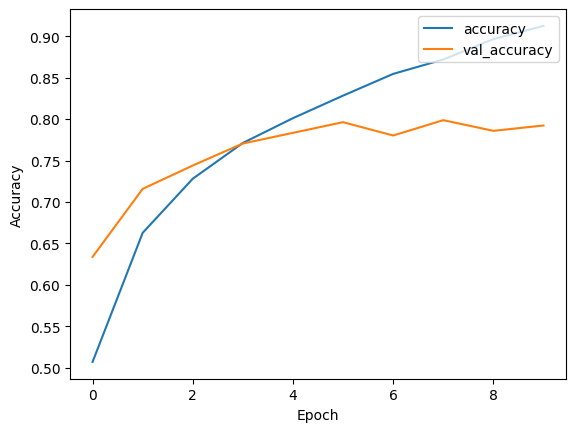

In [28]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

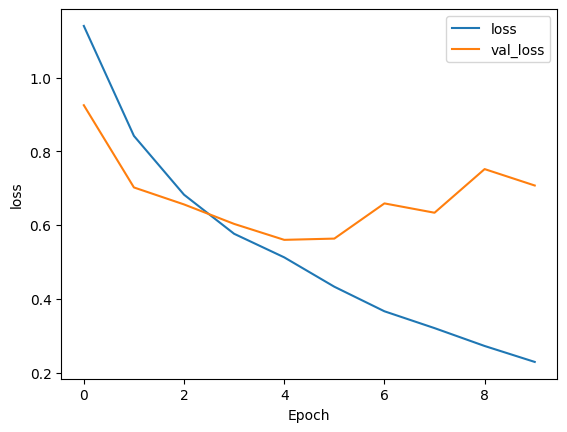

In [29]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

MODEL 2

In [30]:
# Membuat model menggunakan Sequential
model1 = Sequential()

# Convolutional layers
model1.add(Conv3D(64, (3, 3, 3), activation='relu', input_shape=(30, 64, 64, 1)))  # Ubah sesuai input shape Anda
model1.add(MaxPool3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(128, (3, 3, 3), activation='relu',padding = 'same'))
model1.add(MaxPool3D(pool_size=(2, 2, 2)))

# ConvLSTM2D layer
model1.add(ConvLSTM2D(20, (3, 3), activation='relu', return_sequences=True))
model1.add(ConvLSTM2D(40, (3, 3), activation='relu', return_sequences=False))

#Flatten
model1.add(Flatten())

# Dense layers
model1.add(Dense(32, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(5, activation='softmax')) 

In [31]:
# Model compilation
model1.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

# Print summary to verify the architecture
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_13 (Conv3D)              │ (None, 28, 62, 62, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 14, 31, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 14, 31, 31,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 7, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_10 (ConvLSTM2D)     │ (None, 7, 13, 13, 20)  │       106,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)     │ (None, 11, 11, 40)     │        86,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │       154,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,653 (2.19 MB)

 Trainable params: 573,653 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Training
import os
# include the epoch in the file name. (uses `str.format`)

# include the epoch in the file name. (uses `str.format`)
#checkpoint_path = "training_1/cp.keras"
#checkpoint_dir = os.path.dirname(checkpoint_path)

ea_call = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5 ,restore_best_weights=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=False)

# Run the training 
history = model1.fit(x_train, y_train,
                    callbacks = [ea_call],
                    validation_data=(x_val, y_val),
                    batch_size=32,
                    epochs=100)

#os.listdir(checkpoint_dir)

#model1.save(checkpoint_path)

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 73s 254ms/step - accuracy: 0.6677 - loss: 0.8146 - val_accuracy: 0.6554 - val_loss: 0.8133
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.6767 - loss: 0.7953 - val_accuracy: 0.6924 - val_loss: 0.7553
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 249ms/step - accuracy: 0.7089 - loss: 0.7259 - val_accuracy: 0.7110 - val_loss: 0.7234
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 249ms/step - accuracy: 0.7192 - loss: 0.6920 - val_accuracy: 0.7118 - val_loss: 0.7257
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.7339 - loss: 0.6646 - val_accuracy: 0.7230 - val_loss: 0.7167
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.7578 - loss: 0.6028 - val_accuracy: 0.7206 - val_loss: 0.7542
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.7784 - loss: 0.5638 - val_accuracy: 0.7367 - val_loss: 0.6936
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 247ms/step - accuracy: 0.7823 -

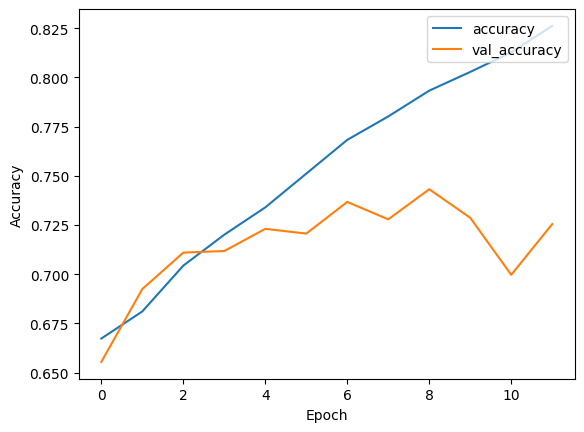

In [34]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

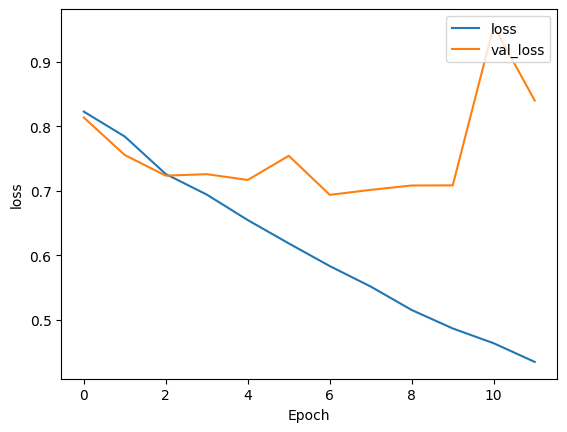

In [35]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

MODEL 3

In [36]:
# Membuat model menggunakan Sequential
model2 = Sequential()

# Convolutional layers
model2.add(Conv3D(64, (3, 3, 3), activation='relu', input_shape=(30, 64, 64, 1)))  # Ubah sesuai input shape Anda
model2.add(MaxPool3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, (3, 3, 3), activation='relu',padding = 'same'))
model2.add(MaxPool3D(pool_size=(2, 2, 2)))

# ConvLSTM2D layer
model2.add(ConvLSTM2D(20, (3, 3), activation='relu', return_sequences=True))
model2.add(ConvLSTM2D(40, (3, 3), activation='relu', return_sequences=False))

#Flatten
model2.add(Flatten())

# Dense layers
model2.add(Dense(32, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(5, activation='softmax')) 

In [37]:
# Model compilation
model2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Print summary to verify the architecture
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_15 (Conv3D)              │ (None, 28, 62, 62, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 14, 31, 31, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_16 (Conv3D)              │ (None, 14, 31, 31,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 7, 15, 15, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_12 (ConvLSTM2D)     │ (None, 7, 13, 13, 20)  │       106,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_13 (ConvLSTM2D)     │ (None, 11, 11, 40)     │        86,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │       154,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,653 (2.19 MB)

 Trainable params: 573,653 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Training
import os
# include the epoch in the file name. (uses `str.format`)

# include the epoch in the file name. (uses `str.format`)
#checkpoint_path = "training_1/cp.keras"
#checkpoint_dir = os.path.dirname(checkpoint_path)

ea_call = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5 ,restore_best_weights=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=False)

# Run the training 
history2 = model2.fit(x_train, y_train,
                    callbacks = [ea_call],
                    validation_data=(x_val, y_val),
                    batch_size=32,
                    epochs=100)

#os.listdir(checkpoint_dir)

#model1.save(checkpoint_path)

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 75s 251ms/step - accuracy: 0.2070 - loss: 1.6097 - val_accuracy: 0.2472 - val_loss: 1.6061
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.2893 - loss: 1.5693 - val_accuracy: 0.4662 - val_loss: 1.3532
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 249ms/step - accuracy: 0.5361 - loss: 1.1072 - val_accuracy: 0.5902 - val_loss: 1.0244
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.5969 - loss: 0.9647 - val_accuracy: 0.6586 - val_loss: 0.8608
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.6413 - loss: 0.8800 - val_accuracy: 0.6675 - val_loss: 0.8593
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 247ms/step - accuracy: 0.6640 - loss: 0.8233 - val_accuracy: 0.7021 - val_loss: 0.7593
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 247ms/step - accuracy: 0.7009 - loss: 0.7540 - val_accuracy: 0.6924 - val_loss: 0.7605
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 71s 247ms/step - accuracy: 0.7200 -

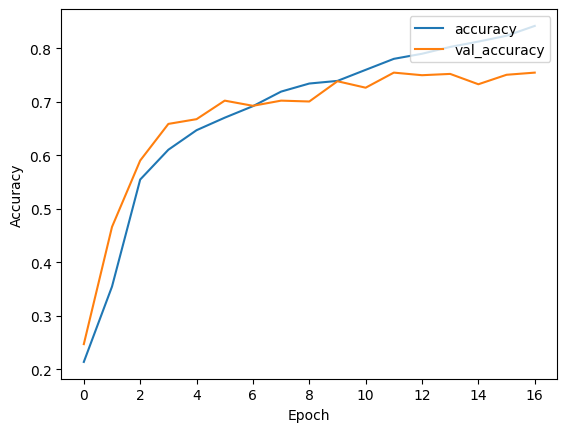

In [39]:
plt.plot(history2.history['accuracy'],label='accuracy')
plt.plot(history2.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

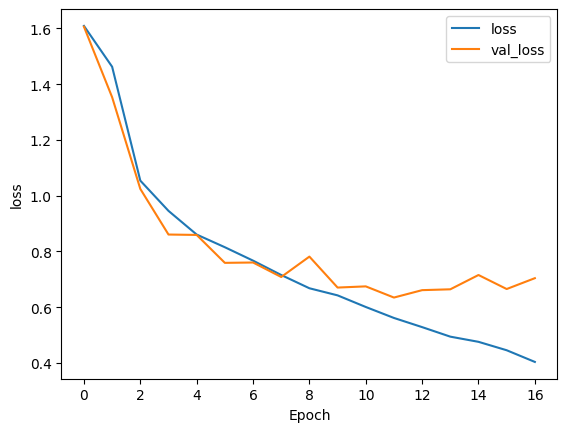

In [40]:
plt.plot(history2.history['loss'],label='loss')
plt.plot(history2.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

EVALUASI MODEL DENGAN DATA TEST

In [41]:
test_vid = ('/kaggle/input/dl-data/data_test')

In [42]:
def load_data_test(path):
    dir = os.listdir(path)

    new_frames = []
    for directory in dir:
        new_frame = []
        
        # Skip jika terdapat file csv
        if directory.endswith('.csv'):
                print(f"Skipping CSV file: {directory}")
                continue
                
        frames = kepastian_frame(os.path.join(path,directory))

        for frame in frames:
            frame = resize_vid(os.path.join(path,directory,frame))
            new_frame.append(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))
        new_frames.append(new_frame)


    new_frames_in_narray = np.array(new_frames[:],dtype = np.float32)
    free_ram(new_frames)
    scaled_images = normalize(new_frames_in_narray)

    return scaled_images
    

In [43]:
x_test = load_data_test(test_vid)

Skipping CSV file: test.csv
old mean 105.920074
new mean -1.9619861e-09
(10, 30, 64, 64, 1)


In [45]:
dl = load_model(checkpoint_path)

y_pred = dl.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [46]:
y_pred

array([[5.37109971e-01, 1.71781343e-03, 7.90423006e-02, 3.73232156e-01,
        8.89780186e-03],
       [4.18421812e-02, 8.47016633e-01, 9.97029711e-03, 7.40545541e-02,
        2.71162614e-02],
       [5.67079604e-01, 2.95385922e-04, 1.49802202e-02, 4.12684351e-01,
        4.96043358e-03],
       [1.13161141e-03, 9.83965516e-01, 3.10322182e-04, 5.35744475e-03,
        9.23508033e-03],
       [1.07273646e-01, 1.10719809e-02, 6.11446738e-01, 1.92636400e-01,
        7.75712132e-02],
       [1.88452065e-01, 1.41142824e-04, 1.81142781e-02, 7.79498994e-01,
        1.37936128e-02],
       [9.25853252e-02, 7.01441022e-05, 3.25953253e-02, 8.36095393e-01,
        3.86537835e-02],
       [2.68704742e-01, 1.52109470e-03, 5.62046692e-02, 6.29000366e-01,
        4.45691459e-02],
       [6.14680015e-02, 9.41186852e-04, 8.20249915e-01, 5.88881001e-02,
        5.84528893e-02],
       [1.41753733e-01, 1.21908830e-02, 2.04958558e-01, 2.10993797e-01,
        4.30103034e-01]], dtype=float32)

In [47]:
y_pred_array=np.argmax(y_pred,axis = 1)+1
y_pred_array = np.array(y_pred_array)

In [48]:
y_pred_array

array([1, 2, 1, 2, 3, 4, 4, 4, 3, 5])

In [49]:
y_test = [3,5,4,2,1,2,4,5,4,3]
y_test = np.array(y_test)
y_test

array([3, 5, 4, 2, 1, 2, 4, 5, 4, 3])

In [50]:
from sklearn.metrics import confusion_matrix,classification_report

# Pastikan y_val tidak perlu np.argmax jika sudah berupa label 1D
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Jika y_test one-hot encoded
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test

# Hitung confusion matrix
met = confusion_matrix(y_test_classes, y_pred_array)
print(met)

[[0 0 1 0 0]
 [0 1 0 1 0]
 [1 0 0 0 1]
 [1 0 1 1 0]
 [0 1 0 1 0]]


In [51]:
import itertools
def confusion_matrix_plot(cm, classes,
                          title='Normalized Confusion Matrix',
                          normalize=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

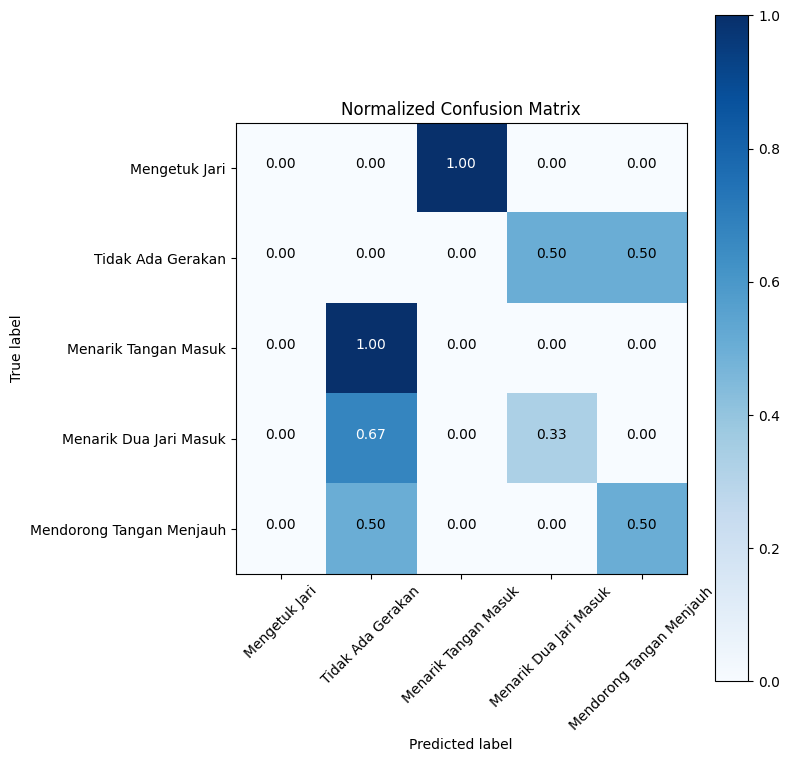

In [38]:
confusion_matrix_plot(met, classes=['Mengetuk Jari','Tidak Ada Gerakan','Menarik Tangan Masuk','Menarik Dua Jari Masuk','Mendorong Tangan Menjauh'])

In [52]:
print(classification_report(y_test_classes, y_pred_array))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      0.50      0.50         2
           3       0.00      0.00      0.00         2
           4       0.33      0.33      0.33         3
           5       0.00      0.00      0.00         2

    accuracy                           0.20        10
   macro avg       0.17      0.17      0.17        10
weighted avg       0.20      0.20      0.20        10

